# Segmentation of water using U-Net

In this notebook we will study Segmentation using a dataset from Kaggle named <a href="https://www.kaggle.com/datasets/gvclsu/water-segmentation-dataset"> Water Segmentation Dataset </a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
DATASET_PATH = '/content/gdrive/MyDrive/Collab/water_dataset'

Mounted at /content/gdrive


In [2]:
import tensorflow as tf

TARGET_SHAPE = (512, 512)
BATCH_SIZE = 8

def preprocess_image(filename):
    """
    Load the specified file as a BMP image, preprocess it and
    resize it to the target shape.
    """
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.math.divide(img, 255)
    img = tf.image.resize(img, TARGET_SHAPE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

def preprocess_mask(filename):
    """
    Load the specified file as a BMP image, preprocess it and
    resize it to the target shape.
    """
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=1, expand_animations = False)
    img = tf.where(img > 128, 1, 0)
    img = tf.image.resize(img, TARGET_SHAPE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

In [3]:
import os
import numpy as np

from sklearn.model_selection import train_test_split

dicImages = {}
dataset_x = []; dataset_y = []
for img in os.listdir(DATASET_PATH+'/Annotations/ADE20K'):
  for img2 in os.listdir(DATASET_PATH+'/JPEGImages/ADE20K'):
    if(img[:-4] == img2[:-4]):  #Check if both images are present
      dataset_x.append(DATASET_PATH+'/JPEGImages/ADE20K/'+img2)
      dataset_y.append(DATASET_PATH+'/Annotations/ADE20K/'+img)

for img in os.listdir(DATASET_PATH+'/Annotations/river_segs'):
  for img2 in os.listdir(DATASET_PATH+'/JPEGImages/river_segs'):
    if(img[:-4] == img2[:-4]):
      dataset_x.append(DATASET_PATH+'/JPEGImages/river_segs/'+img2)
      dataset_y.append(DATASET_PATH+'/Annotations/river_segs/'+img)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
    
x_train, x_val, y_train, y_val = train_test_split(dataset_x, dataset_y, test_size=0.1)

print(dataset_x.shape, dataset_y.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

del(dataset_x)
del(dataset_y)

(2188,) (2188,)
(1969,) (1969,)
(219,) (219,)


In [4]:
from sklearn.utils import shuffle

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, x2, batch_size, shuffle=True):
        'Initialization'
        self.x = x
        self.x2 = x2
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch_tmp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = []
        for f in x1_batch_tmp: x1_batch.append(preprocess_image(f))
        x1_batch = np.array(x1_batch)
        
        x2_batch_tmp = self.x2[index*self.batch_size:(index+1)*self.batch_size]
        x2_batch = []
        for f in x2_batch_tmp: x2_batch.append(preprocess_mask(f))
        x2_batch = np.array(x2_batch)
                
        return x1_batch, x2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.x2 = shuffle(self.x, self.x2)

In [5]:
train_gen = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DataGenerator(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(input)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def get_autoencoder():
    inputs = layers.Input(TARGET_SHAPE + (3,))

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net-like")
    model.summary()
    return model

model = get_autoencoder()

Model: "U-Net-like"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                        

In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Nadam(),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=20)

Epoch 1/20
246/246 [==============================] - 617s 2s/step - loss: 0.5321 - accuracy: 0.7467 - val_loss: 3.5032 - val_accuracy: 0.6612
Epoch 2/20
246/246 [==============================] - 566s 2s/step - loss: 0.4357 - accuracy: 0.7970 - val_loss: 1.4113 - val_accuracy: 0.6069
Epoch 3/20
246/246 [==============================] - 566s 2s/step - loss: 0.4138 - accuracy: 0.8116 - val_loss: 0.7463 - val_accuracy: 0.6549
Epoch 4/20
246/246 [==============================] - 566s 2s/step - loss: 0.3856 - accuracy: 0.8251 - val_loss: 0.4812 - val_accuracy: 0.7738
Epoch 5/20
246/246 [==============================] - 566s 2s/step - loss: 0.3750 - accuracy: 0.8311 - val_loss: 0.4038 - val_accuracy: 0.8312
Epoch 6/20
246/246 [==============================] - 566s 2s/step - loss: 0.3671 - accuracy: 0.8364 - val_loss: 0.3820 - val_accuracy: 0.8276
Epoch 7/20
246/246 [==============================] - 567s 2s/step - loss: 0.3614 - accuracy: 0.8386 - val_loss: 0.3734 - val_accuracy: 0.8396

In [8]:
model.save_weights('autoencoder_weight.h5')

In [9]:
model.load_weights('autoencoder_weight.h5')

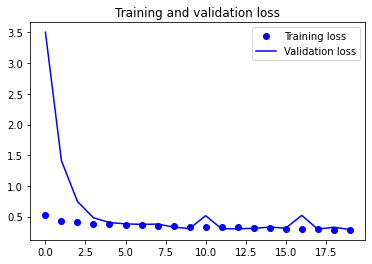

In [11]:
import matplotlib.pyplot as plt
import random

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(20)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

/content/gdrive/MyDrive/Collab/water_dataset/JPEGImages/ADE20K/ADE_train_00014677.png
/content/gdrive/MyDrive/Collab/water_dataset/Annotations/ADE20K/ADE_train_00014677.png


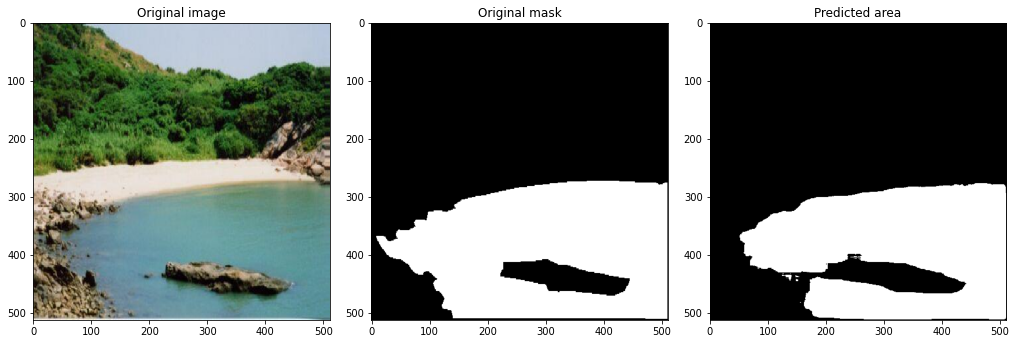

In [47]:
def MakeMask(imgMask, ind):
  imgMask = tf.where(imgMask > ind, 255, 0)
  imgMask = np.array(imgMask)
  imgMask1 = np.zeros((imgMask.shape[0],imgMask.shape[1],3),dtype = np.uint8)
  for i in range(imgMask.shape[0]):
    for j in range(imgMask.shape[1]):
      if imgMask[i][j][0] == 0:
        imgMask1[i][j][0] = imgMask1[i][j][1] = imgMask1[i][j][2] = 0
      else:
        imgMask1[i][j][0] = imgMask1[i][j][1] = imgMask1[i][j][2] = 255
  return imgMask1

rnd = random.randint(0, x_val.shape[0])
print(x_val[rnd])
print(y_val[rnd])

randomImage = preprocess_image(x_val[rnd])
randomImage = np.expand_dims(randomImage, axis=0)

randomImageMask = preprocess_mask(y_val[rnd])
randomImageMask1 = MakeMask(randomImageMask, 0)

pred = model.predict(randomImage)[0]
pred1 = MakeMask(pred, 0.5)

fig, ax = plt.subplots(1, 3,figsize=(14, 1*7), constrained_layout=True)

ax[0].set_title('Original image')
ax[0].imshow(randomImage[0])

ax[1].set_title('Original mask')
ax[1].imshow(np.squeeze(randomImageMask1))

ax[2].set_title('Predicted area')
ax[2].imshow(np.squeeze(pred1))